In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

# Online Outcomes: Predicting Success in Virtual Learning

**<font size="4">Author: Jeffrey Hanif Watson</font>**

## Project Alpha = .05

## Imports and Project Path

In [2]:
# importing packages
import os, sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import sqlite3

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

from dython.nominal import associations

from src import class_Database as d
from src import helper_functions as f
from src import visualizations as v

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

time: 7.78 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.55 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 507 µs


## Creating SQL `conn`, `cur`

In [5]:
data_path = os.path.join(gparent,'data/processed','outcomes.db')
conn = sqlite3.connect(data_path)  
cur = conn.cursor()

time: 5.59 ms


### Database ERD

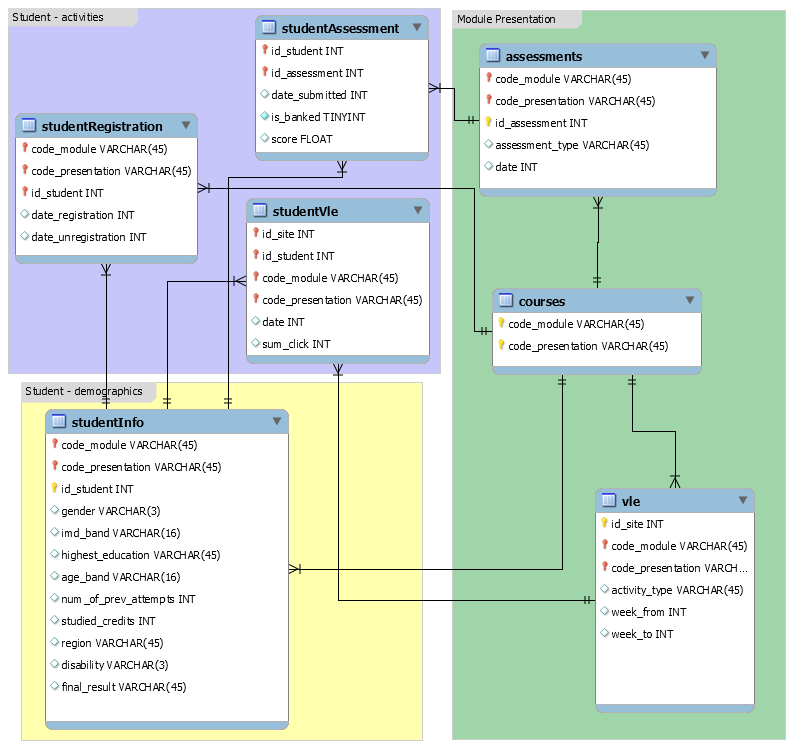

time: 4.01 ms


In [6]:
db.erd

## EDA

### Checking table names

In [7]:
# checking the table names
db.table_names()

['ASSESSMENTS',
 'COURSES',
 'STUDENTASSESSMENT',
 'STUDENTINFO',
 'STUDENTREGISTRATION',
 'STUDENTVLE',
 'VLE']

time: 2.96 ms


## Data Understanding

### Codes & Module Summaries

In [8]:
# month codes used in code_presentation
db.month_codes

{'A': 'January',
 'B': 'Februrary',
 'C': 'March',
 'D': 'April',
 'E': 'May',
 'F': 'June',
 'G': 'July',
 'H': 'August',
 'I': 'Septemeber',
 'J': 'October',
 'K': 'November',
 'L': 'December'}

time: 2.03 ms


In [9]:
# module codes and summaries
db.module_codes

{'AAA': {'Domain': 'Social Sciences', 'Presentations': 2, 'Students': 748},
 'BBB': {'Domain': 'Social Sciences', 'Presentations': '4', 'Students': 7909},
 'CCC': {'Domain': 'STEM', 'Presentations': 2, 'Students': 4434},
 'DDD': {'Domain': 'STEM', 'Presentations': 4, 'Students': 6272},
 'EEE': {'Domain': 'STEM', 'Presentations': 3, 'Students': 2934},
 'FFF': {'Domain': 'STEM', 'Presentations': 4, 'Students': 7762},
 'GGG': {'Domain': 'Social Sciences', 'Presentations': 3, 'Students': 2534}}

time: 2.76 ms


## VLE Table

In [10]:
vle = db.simple_df('VLE')
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,None,None
1,546712,AAA,2013J,oucontent,None,None
2,546998,AAA,2013J,resource,None,None
3,546888,AAA,2013J,url,None,None
4,547035,AAA,2013J,resource,None,None


time: 25.3 ms


## COURSES Table

In [11]:
courses = db.simple_df('COURSES')
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


time: 7.68 ms


## ASSESSMENTS Table

In [12]:
assess_df = db.simple_df('ASSESSMENTS')
assess_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19,10
1,AAA,2013J,1753,TMA,54,20
2,AAA,2013J,1754,TMA,117,20
3,AAA,2013J,1755,TMA,166,20
4,AAA,2013J,1756,TMA,215,30


time: 8.72 ms


## STUDENTREGISTRATION Table

In [13]:
stureg = db.simple_df('STUDENTREGISTRATION')
stureg.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159,None
1,AAA,2013J,28400,-53,None
2,AAA,2013J,30268,-92,12
3,AAA,2013J,31604,-52,None
4,AAA,2013J,32885,-176,None


time: 80.9 ms


In [14]:
# creating row_id
stureg['row_id'] = stureg.code_module + stureg.code_presentation + stureg.id_student

time: 10.3 ms


In [15]:
# moving to front of df
f.col_pop(stureg, 'row_id')

time: 2.42 ms


In [16]:
# checking work
stureg.head()

,row_id,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA2013J11391,AAA,2013J,11391,-159,None
1,AAA2013J28400,AAA,2013J,28400,-53,None
2,AAA2013J30268,AAA,2013J,30268,-92,12
3,AAA2013J31604,AAA,2013J,31604,-52,None
4,AAA2013J32885,AAA,2013J,32885,-176,None


time: 7.39 ms


## Student Info Table

In [17]:
# creating student_info data frame
student_info = db.simple_df('STUDENTINFO')

time: 161 ms


In [18]:
# checking first five rows
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


time: 9.5 ms


In [19]:
# checking info
student_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  object
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  object
 9   studied_credits       32593 non-null  object
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: object(12)
memory usage: 3.0+ MB
time: 30 ms


In [20]:
# checking for nulls
student_info.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

time: 23 ms


We have 1100 null values in the imd_band column. We'll drop them for now.

In [21]:
# dropping nulls
student_info = student_info.dropna()

time: 34.5 ms


In [22]:
# checking work
student_info.isna().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64

time: 26.7 ms


In [23]:
# checking new shape
student_info.shape

(31482, 12)

time: 1.9 ms


In [24]:
corr1 = associations(student_info, figsize=(20,20), cmap='GnBu_r')

time: 541 µs


### Share of Outcomes By Type

In [25]:
student_info.final_result.value_counts(normalize=True)

Pass           0.375770
Withdrawn      0.315101
Fail           0.219395
Distinction    0.089734
Name: final_result, dtype: float64

time: 11.2 ms


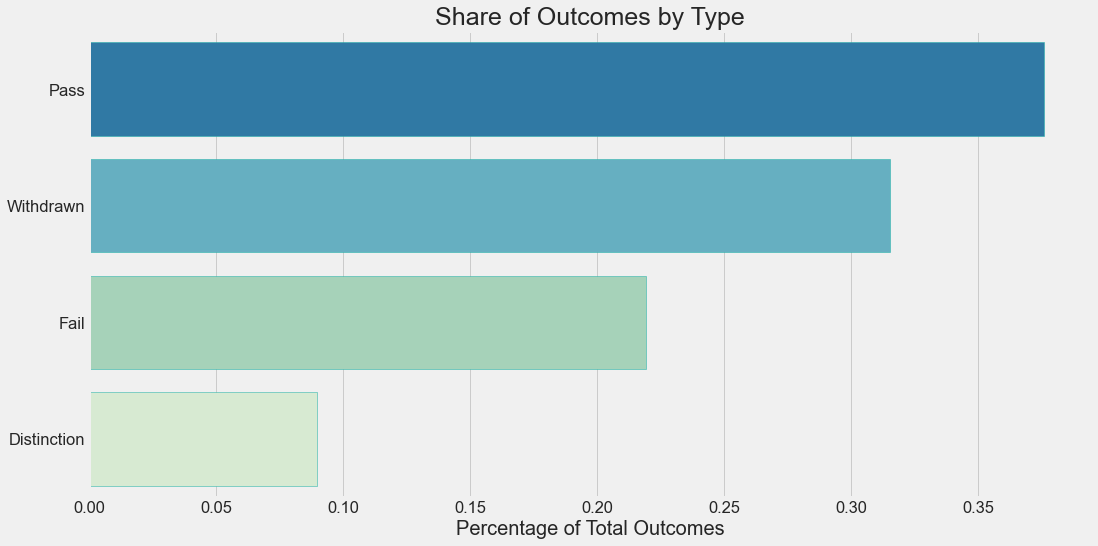

time: 387 ms


In [26]:
v.outcomes_type(student_info, 'outcomes_type')

### Share of Outcomes by Module

In [158]:
# percentage of data for each module
student_info.code_module.value_counts(normalize=True)

BBB    0.249165
FFF    0.234042
DDD    0.190021
CCC    0.132899
EEE    0.090130
GGG    0.081107
AAA    0.022637
Name: code_module, dtype: float64

time: 8.18 ms


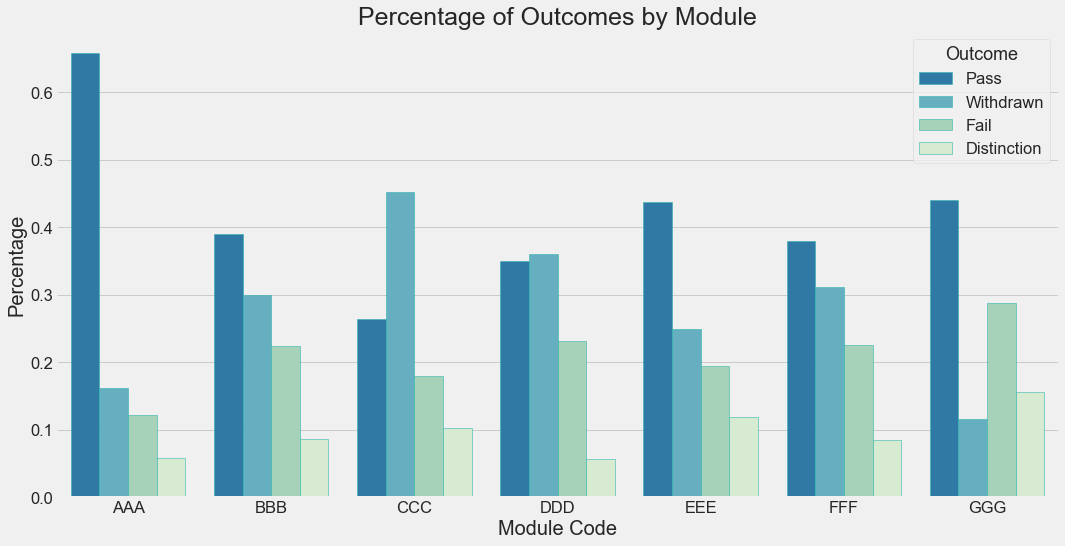

time: 237 ms


In [155]:
v.outcomes_mod(student_info)

### Share of Outcomes By Presentation

In [160]:
# percentage of data for each presentation
student_info.code_presentation.value_counts(normalize=True)

2014J    0.345107
2013J    0.272605
2014B    0.239854
2013B    0.142435
Name: code_presentation, dtype: float64

time: 9.24 ms


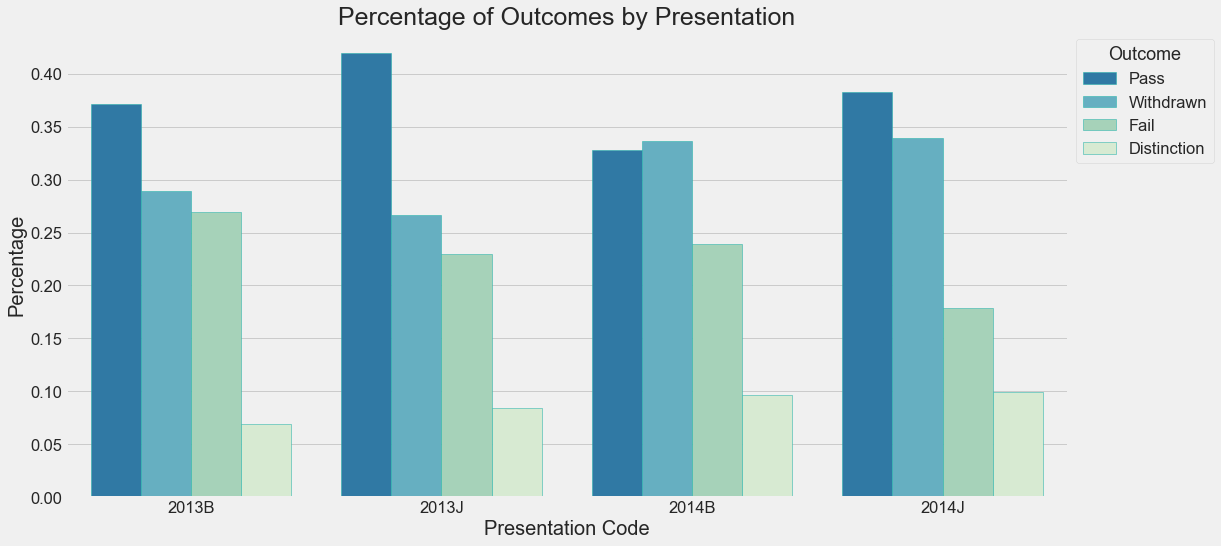

time: 225 ms


In [157]:
v.outcomes_pres(student_info)

### Outcomes By IMD Band

In [27]:
student_info['imd_band'].unique()

array(['90-100%', '20-30%', '30-40%', '50-60%', '80-90%', '70-80%',
       '60-70%', '40-50%', '10-20', '0-10%'], dtype=object)

time: 5.74 ms


In [28]:
student_info['imd_band'].value_counts(normalize=True)

20-30%     0.116066
30-40%     0.112413
10-20      0.111683
0-10%      0.105171
40-50%     0.103424
50-60%     0.099231
60-70%     0.092275
70-80%     0.091449
80-90%     0.087733
90-100%    0.080554
Name: imd_band, dtype: float64

time: 9.57 ms


In [29]:
# fixing typo
student_info['imd_band'] = student_info['imd_band'].replace(['10-20'], '10-20%')

time: 8.84 ms


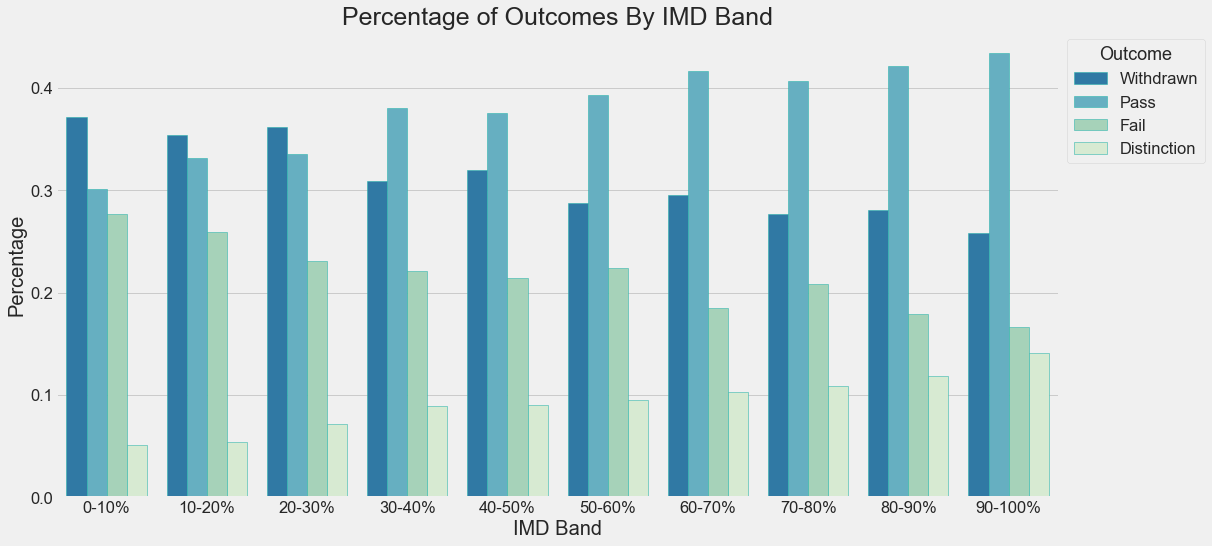

time: 598 ms


In [30]:
v.outcomes_imd(student_info, 'outcomes_imd')

### Outcomes By Disability Status

In [31]:
student_info['disability'].value_counts(normalize=True)

N    0.900546
Y    0.099454
Name: disability, dtype: float64

time: 5.14 ms


In [32]:
# renaming values
student_info['disability'] = student_info['disability'].replace(['Y', 'N'], ['Yes', 'No'])

time: 4.82 ms


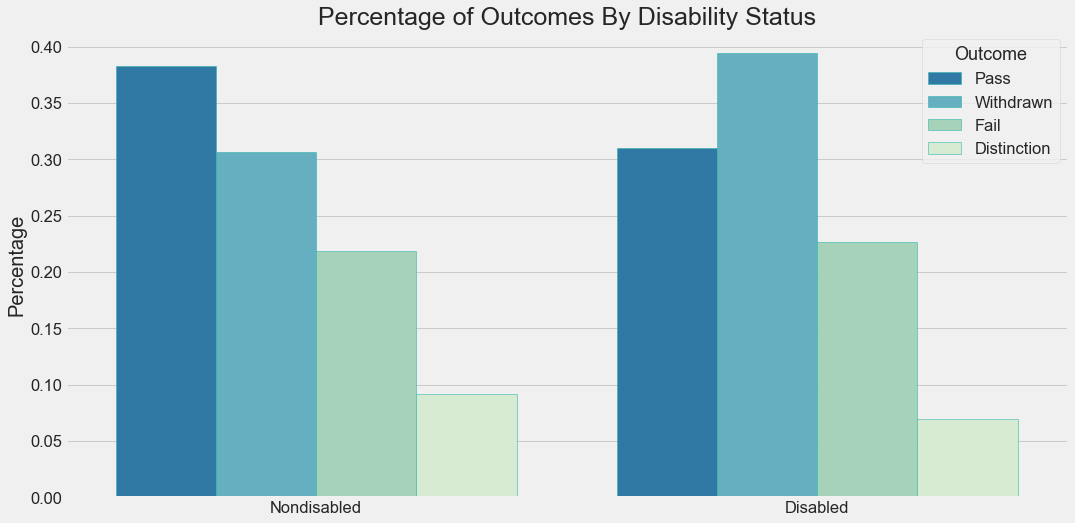

time: 360 ms


In [33]:
v.outcomes_dis(student_info, 'outcomes_dis')

### Outcomes By Age Band

In [34]:
student_info.age_band.value_counts(normalize=True)

0-35     0.707452
35-55    0.286164
55<=     0.006385
Name: age_band, dtype: float64

time: 7.89 ms


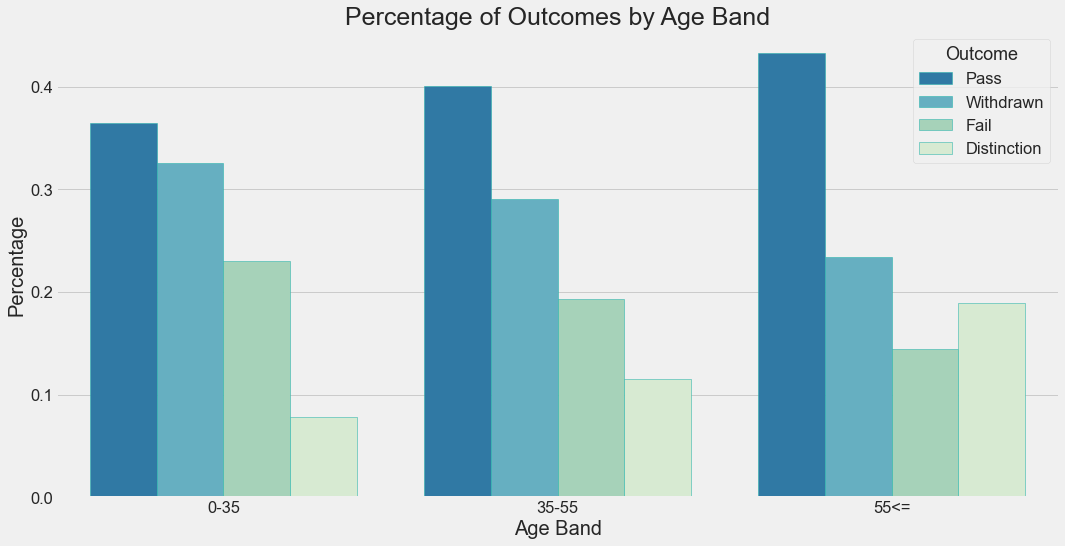

time: 360 ms


In [35]:
v.outcomes_age(student_info, 'outcomes_age')

### Outcomes By Education Level

In [36]:
student_info.highest_education.value_counts(normalize=True)

A Level or Equivalent          0.437139
Lower Than A Level             0.405374
HE Qualification               0.141160
No Formal quals                0.010419
Post Graduate Qualification    0.005908
Name: highest_education, dtype: float64

time: 6.68 ms


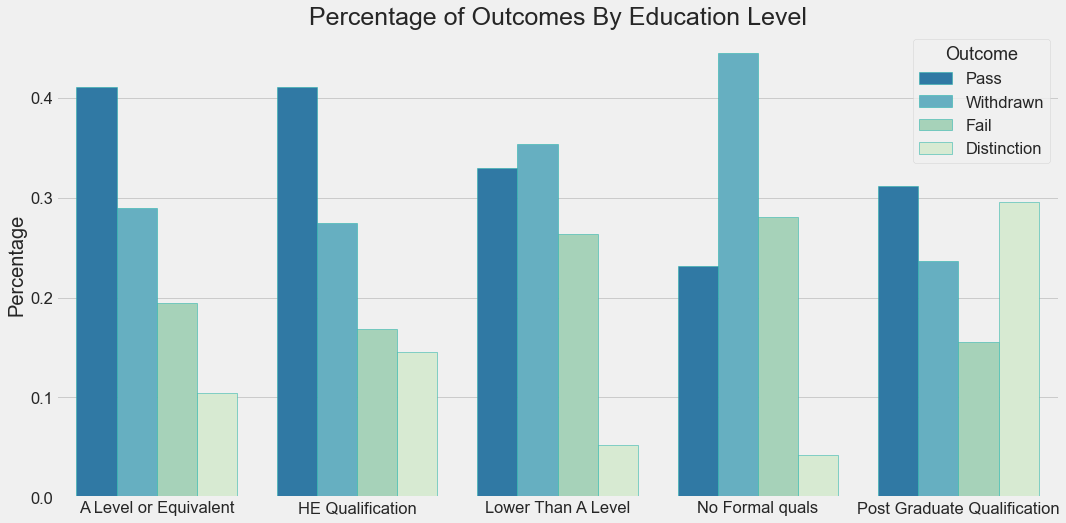

time: 497 ms


In [37]:
v.outcomes_edu(student_info, 'outcomes_edu')

### Outcomes By Gender

In [38]:
student_info.gender.value_counts(normalize=True)

M    0.542119
F    0.457881
Name: gender, dtype: float64

time: 5.2 ms


In [39]:
# renaming values
student_info['gender'] = student_info['gender'].replace(['M', 'F'], ['Male', 'Female'])

time: 4.93 ms


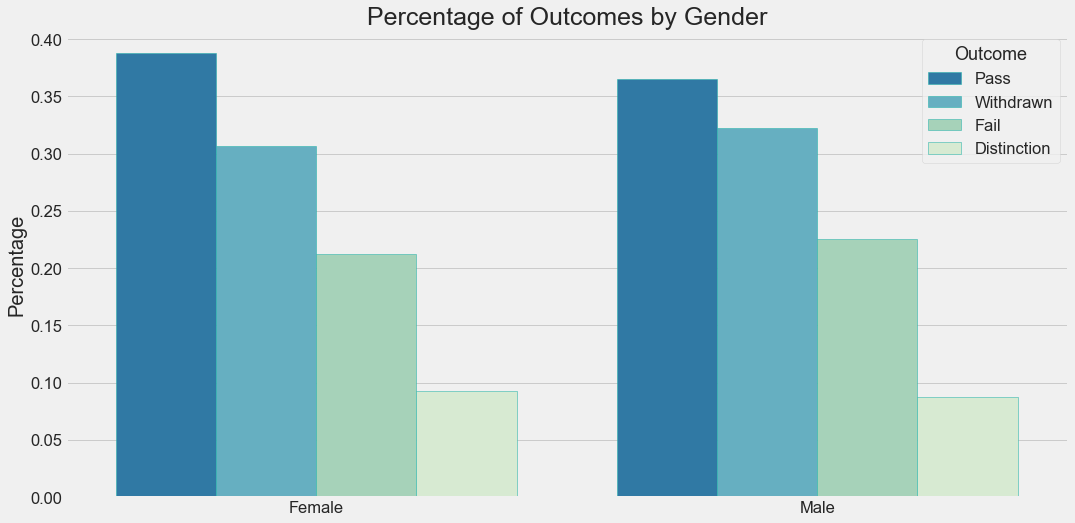

time: 328 ms


In [40]:
v.outcomes_gen(student_info, 'outcomes_gen')

### Outcomes by Region

In [41]:
student_info.region.value_counts(normalize=True)

Scotland                0.109078
East Anglian Region     0.106092
London Region           0.102154
South Region            0.096690
North Western Region    0.092148
West Midlands Region    0.080776
South West Region       0.077219
East Midlands Region    0.075122
South East Region       0.067054
Wales                   0.066260
Yorkshire Region        0.063560
North Region            0.034686
Ireland                 0.029160
Name: region, dtype: float64

time: 8.95 ms


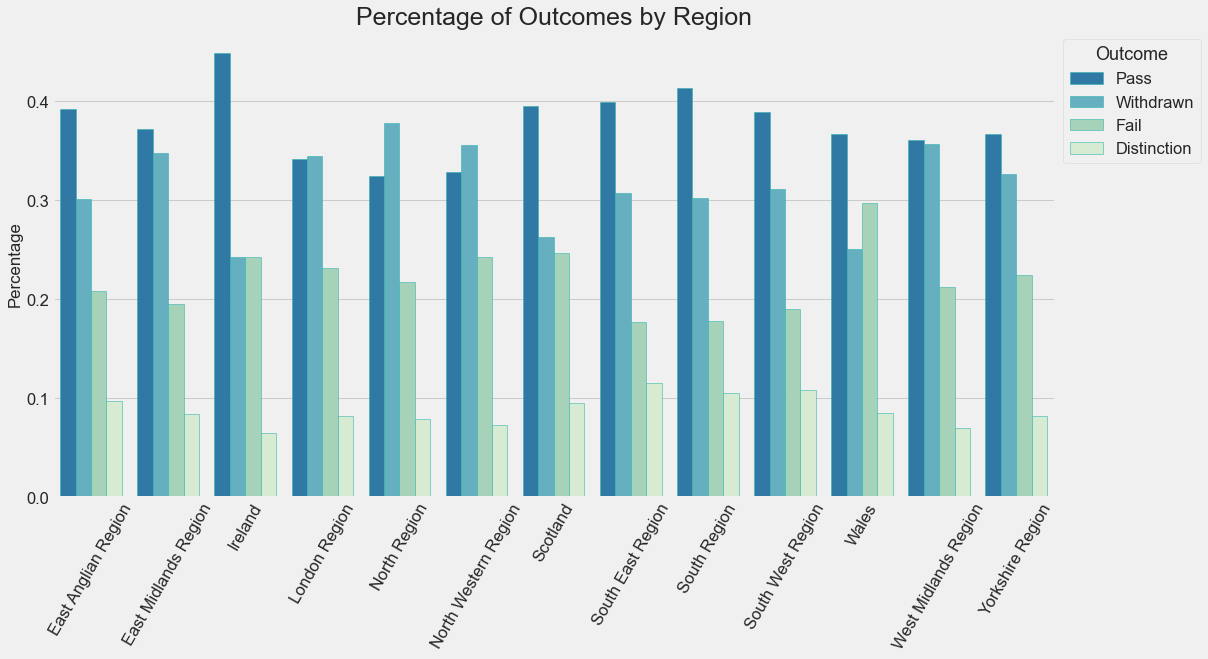

time: 380 ms


In [42]:
v.outcomes_reg(student_info)

### Outcomes by Course Load

In [43]:
# converting data type to numeric
student_info['studied_credits'] = student_info['studied_credits']\
.map(pd.to_numeric)

time: 370 ms


In [44]:
# checking summary stats
student_info['studied_credits'].describe() 

count    31482.000000
mean        79.767804
std         41.049455
min         30.000000
25%         60.000000
50%         60.000000
75%        120.000000
max        655.000000
Name: studied_credits, dtype: float64

time: 5.37 ms


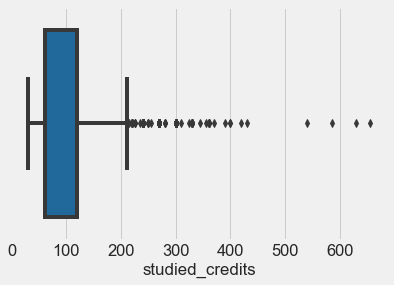

time: 105 ms


In [45]:
sns.boxplot(x=student_info['studied_credits']);

## Dealing With Outliers Using IQR Fences.

In [46]:
student_info['studied_credits'].shape

(31482,)

time: 2.68 ms


In [47]:
Q1 = student_info.studied_credits.quantile(0.25)
Q3 = student_info.studied_credits.quantile(0.75)
IQR = Q3 - Q1
IQR

60.0

time: 7.26 ms


In [48]:
# checking the Stats of the outliers
student_info[((student_info['studied_credits'] < (Q1 - 1.5 * IQR))\
     | (student_info['studied_credits'] >\
        (Q3 + 1.5 * IQR)))]['studied_credits'].describe()

count    338.000000
mean     261.227811
std       51.340068
min      215.000000
25%      240.000000
50%      240.000000
75%      270.000000
max      655.000000
Name: studied_credits, dtype: float64

time: 6.27 ms


In [49]:
student_info = student_info[~((student_info.studied_credits < (Q1 - 1.5 * IQR))\
                              |(student_info.studied_credits > (Q3 + 1.5 * IQR)))].copy()

time: 12.2 ms


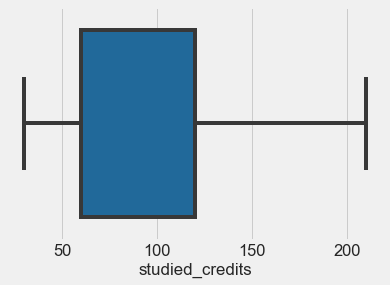

time: 116 ms


In [50]:
# checking boxplot after cleaning
sns.boxplot(x=student_info['studied_credits']);

### Median & Mean Study Credits

In [51]:
# checking mean
student_info.studied_credits.mean()

77.79845235037246

time: 2.47 ms


In [52]:
# checking median
student_info.studied_credits.median()

60.0

time: 3.35 ms


### Binning Data

In [53]:
# binning data
pd.qcut(student_info.studied_credits, q=4, duplicates='drop').unique()

[(29.999, 60.0], (60.0, 120.0], (120.0, 210.0]]
Categories (3, interval[float64]): [(29.999, 60.0] < (60.0, 120.0] < (120.0, 210.0]]

time: 10.2 ms


### Adding `course_load` Category

In [54]:
# adding course_load category
student_info['course_load'] = pd.qcut(student_info.studied_credits, q=4,\
                                      labels=['Light', 'Medium', 'Heavy'],\
                                      duplicates='drop')

time: 5.26 ms


In [55]:
# checking work
print(f'{student_info.course_load.unique()} \n' )
student_info.info()

['Light', 'Medium', 'Heavy']
Categories (3, object): ['Light' < 'Medium' < 'Heavy'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31144 entries, 1 to 32592
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   code_module           31144 non-null  object  
 1   code_presentation     31144 non-null  object  
 2   id_student            31144 non-null  object  
 3   gender                31144 non-null  object  
 4   region                31144 non-null  object  
 5   highest_education     31144 non-null  object  
 6   imd_band              31144 non-null  object  
 7   age_band              31144 non-null  object  
 8   num_of_prev_attempts  31144 non-null  object  
 9   studied_credits       31144 non-null  int64   
 10  disability            31144 non-null  object  
 11  final_result          31144 non-null  object  
 12  course_load           31144 non-null  category
dtypes: category(1), int6

In [56]:
# checking value_counts
student_info.course_load.value_counts(normalize=True)

Light     0.637940
Medium    0.302787
Heavy     0.059273
Name: course_load, dtype: float64

time: 27.4 ms


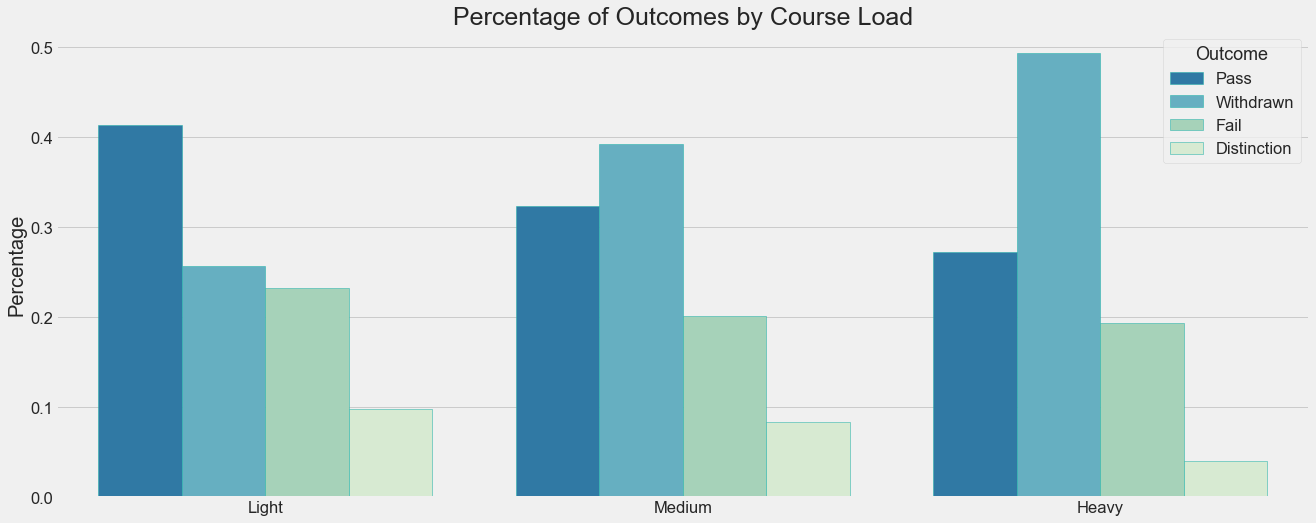

time: 468 ms


In [57]:
v.outcome_cl(student_info, 'outcomes_cl')

## Investigating `course_load`

In [58]:
# creating a contingency table
tabs = pd.crosstab(student_info.course_load, student_info.final_result)

time: 17.2 ms


In [59]:
# creating a statsmodels table object
table = sm.stats.Table(tabs)

time: 855 µs


In [60]:
# the original contingency table
table.table_orig

final_result,Distinction,Fail,Pass,Withdrawn
course_load,,,,
Light,1956,4606,8214,5092
Medium,784,1894,3053,3699
Heavy,74,358,503,911


time: 5.96 ms


In [61]:
# expected values if final_result was independent from course_load
table.fittedvalues

final_result,Distinction,Fail,Pass,Withdrawn
course_load,,,,
Light,1795.162856,4374.991780,7508.552530,6189.292833
Medium,852.042769,2076.513614,3563.803622,2937.639995
Heavy,166.794375,406.494606,697.643848,575.067172


time: 9.27 ms


In [62]:
# pearsons residuals: negatives indicate fewer results than expected, positives indicate more.
table.resid_pearson

final_result,Distinction,Fail,Pass,Withdrawn
course_load,,,,
Light,3.796072,3.492519,8.141165,-13.947682
Medium,-2.331048,-4.005234,-8.556518,14.047233
Heavy,-7.185069,-2.405282,-7.369259,14.008549


time: 11 ms


From the contingency tables it appears that a light course load contributes positively to Distinction, Pass, and (counterintuitively) Fail, while it contributes negatively to Withdrawn. Conversely,  Medium and Heavy course loads contribute negatively to Distinction, Pass and (again, counterintuitively) Fail,  while they contribute positively to Withdrawn.

## Chi-Square Test for `course_load`
Ho = `course_load` and `final_result` are independent.

Ha = `course_load` and `final_result` are not independent.

alpha = .05

In [63]:
# calculating chi-squared,p-value, degrees of freedom
f.chi_sq_test(tabs)

chi-squared = 887.3947035023172
p value= 1.9942967713148247e-188
degrees of freedom = 6
time: 1.45 ms


Since the p value is less than our alpha, we reject the null hypothesis and conclude that `course_load` and `final_result` are not independent.

In [64]:
# calculating cramer's v to measure the effect sizes
f.cramers_v(tabs)

Cramer's V Degrees of Freedom = 2



final_result
Distinction    0.397083
Fail           0.254358
Pass           0.194158
Withdrawn      0.213852
dtype: float64

time: 5.22 ms


Adjusted for degrees of freedom, the Cramer's V results indicate that `course_load` has a small effect on Pass, a medium effect on Withdraw and Fail, and a large effect on Distinction.

## STUDENTVLE Table

In [65]:
# creating simple data frame
svle = db.simple_df('STUDENTVLE')
svle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


time: 25.3 s


In [66]:
# converting datatype to numeric
conversions = ['date', 'sum_click']
svle[conversions] = svle[conversions].apply(pd.to_numeric)

time: 10.5 s


In [67]:
# creating row_id
svle['row_id'] = svle.code_module + svle.code_presentation + svle.id_student

time: 1.68 s


In [68]:
# dropping extraneous columns
svle = svle.drop(columns=['code_module', 'code_presentation', 'id_student'])

time: 2.75 s


In [69]:
# moving row_id to front of data frame
f.col_pop(svle, 'row_id')

time: 310 ms


### Shifting Date

In [70]:
# getting min date
svle.date.min()

-25

time: 15.6 ms


In [71]:
# translating date 25 to the right
svle['date'] = svle['date'] + 25

time: 52.1 ms


In [72]:
svle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   row_id     object
 1   id_site    object
 2   date       int64 
 3   sum_click  int64 
dtypes: int64(2), object(2)
memory usage: 325.2+ MB
time: 5.47 ms


## Joining STUDENTINFO & STUDENTVLE Tables (SQL)

In [73]:
# getting column names and table info
q= "PRAGMA table_info(STUDENTVLE);"
f.fetch(cur, q)

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'id_site', 'TEXT', 0, None, 0),
 (4, 'date', 'TEXT', 0, None, 0),
 (5, 'sum_click', 'TEXT', 0, None, 0)]

time: 3.54 ms


In [74]:
q = """
SELECT SV.*,
SI.*,
SUM(SV.sum_click) AS click_sum,
COUNT(SV.sum_click) AS num_activities,
SV.code_module || SV.code_presentation || SV.id_student AS row_id
FROM 
STUDENTVLE as SV
JOIN 
STUDENTINFO as SI
ON SV.code_module = SI.code_module
AND SV.code_presentation = SI.code_presentation
AND SV.id_student = SI.id_student
GROUP BY 
SV.code_module,
SV.code_presentation,
SV.id_student;
"""
sv_si = pd.read_sql(q, conn)

time: 30.4 s


In [75]:
# cleaning up the data frame
sv_si = f.sv_si_fixes(sv_si)

time: 4.98 s


In [76]:
# moving to front of df
f.col_pop(sv_si, 'row_id')

time: 8.18 ms


In [77]:
sv_si.head(2)

,row_id,target,final_result,code_module,code_presentation,id_student,id_site,date,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_sum,num_activities,course_load
0,AAA2013J100893,1,Pass,AAA,2013J,100893,547013,-9,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,No,744,243,Light
1,AAA2013J101781,1,Pass,AAA,2013J,101781,546614,-10,Male,South Region,Lower Than A Level,80-90%,35-55,0,60,No,4104,913,Light


time: 11.6 ms


In [78]:
# checking work
for col in sv_si.columns:
    print(f'{col}: \n {sv_si[col].unique()}')

row_id: 
 ['AAA2013J100893' 'AAA2013J101781' 'AAA2013J102806' ... 'GGG2014J699461'
 'GGG2014J699628' 'GGG2014J92103']
target: 
 [1 0]
final_result: 
 ['Pass' 'Withdrawn' 'Distinction' 'Fail']
code_module: 
 ['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
code_presentation: 
 ['2013J' '2014J' '2013B' '2014B']
id_student: 
 ['100893' '101781' '102806' ... '699461' '699628' '92103']
id_site: 
 ['547013' '546614' '546719' ... '897145' '897063' '897067']
date: 
 [ -9 -10  -3  12  -5   0   2   3  21  -7  -8  -6  -1  16   1  -2  -4  49
   9  10 -24 -16 -23 -20 -21 -11 -15 -19   7 -17   5  13 -13 -14 -18 -22
  11  23 -12  14  37  18  17   4  15  46  38  19  30  24   6   8  68  33
  40  88  26  22  29  32  25 211  28  27 224  35  55  47 138  31  44  96
 123 122  36 132  51  54 135 120  91  94  59  45 178  20 234 117  63  34
 238  43  39 108  53 189  61 114  56 146  64  87  52 109  48 170 101  69
  60  62 127 102 -25  86 106 144 107 111  42 164  99  89 110 100 119 128
  65 213  57  67  58 145  82 13

In [79]:
# checking types
sv_si.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28174 entries, 0 to 29227
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   row_id                28174 non-null  object
 1   target                28174 non-null  int64 
 2   final_result          28174 non-null  object
 3   code_module           28174 non-null  object
 4   code_presentation     28174 non-null  object
 5   id_student            28174 non-null  object
 6   id_site               28174 non-null  object
 7   date                  28174 non-null  int64 
 8   gender                28174 non-null  object
 9   region                28174 non-null  object
 10  highest_education     28174 non-null  object
 11  imd_band              28174 non-null  object
 12  age_band              28174 non-null  object
 13  num_of_prev_attempts  28174 non-null  int64 
 14  studied_credits       28174 non-null  int64 
 15  disability            28174 non-null

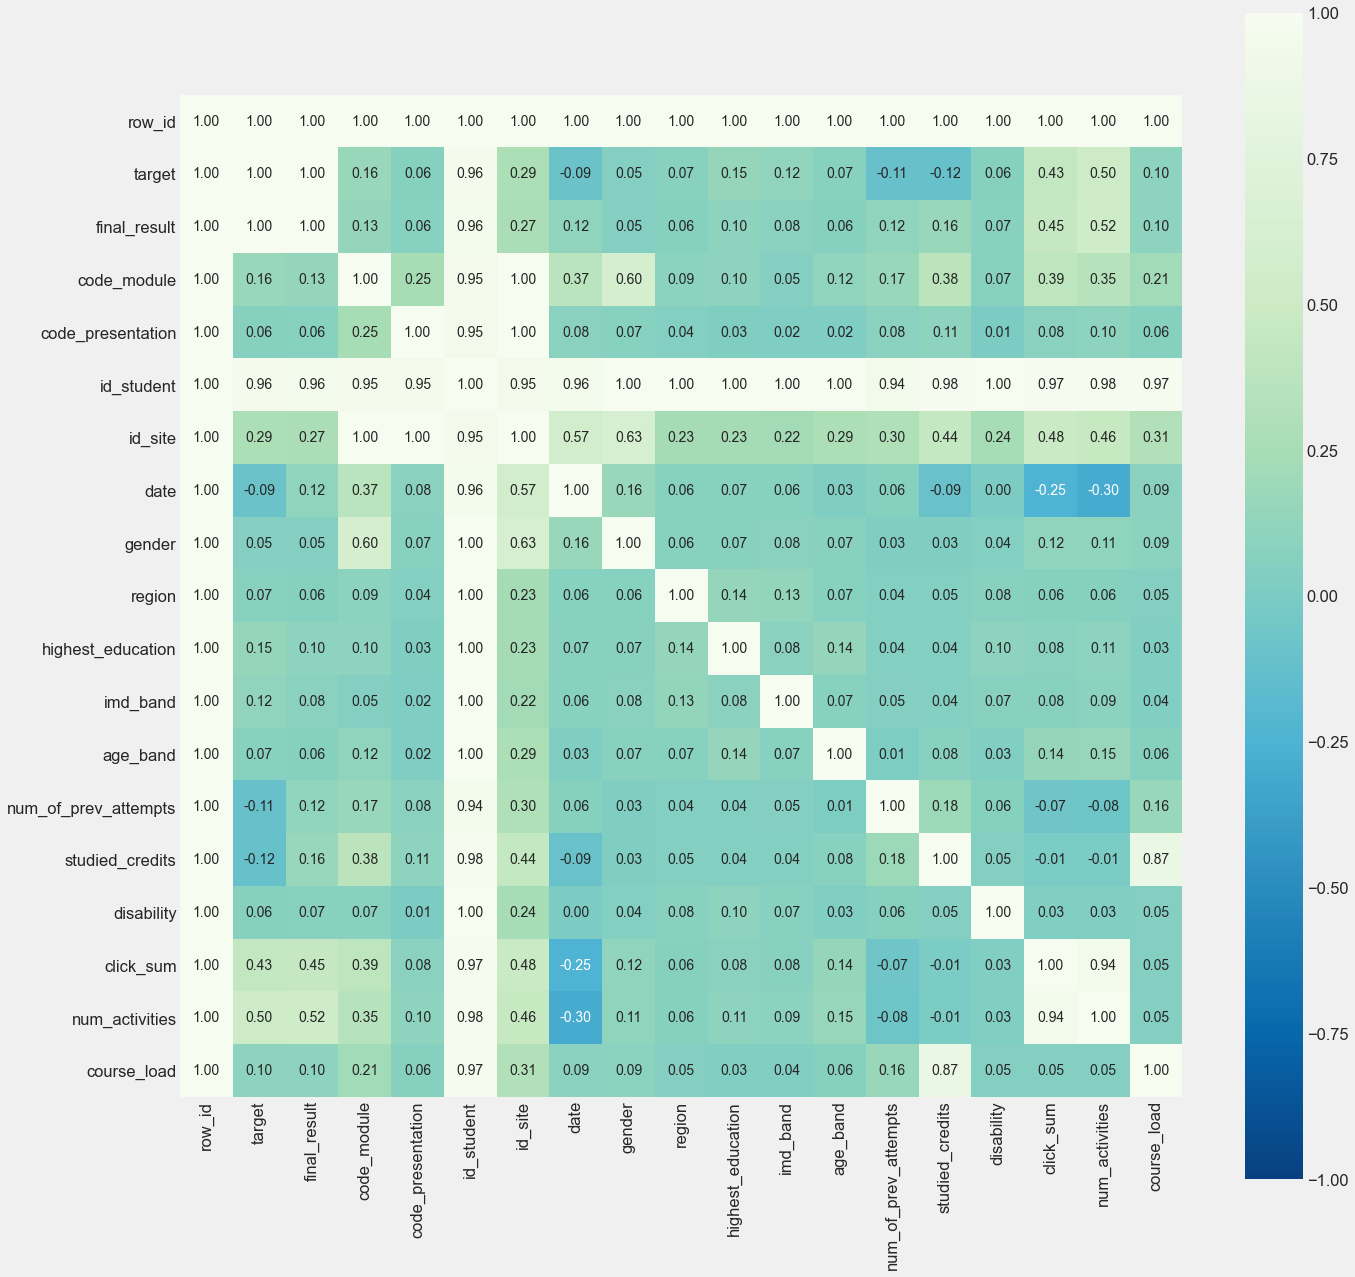

{'corr':                       row_id    target  final_result  code_module  \
 row_id                   1.0  1.000000      1.000000     1.000000   
 target                   1.0  1.000000      1.000000     0.158371   
 final_result             1.0  1.000000      1.000000     0.132984   
 code_module              1.0  0.158371      0.132984     1.000000   
 code_presentation        1.0  0.061185      0.064246     0.248011   
 id_student               1.0  0.963234      0.957930     0.951696   
 id_site                  1.0  0.288198      0.268463     1.000000   
 date                     1.0 -0.089647      0.123474     0.372008   
 gender                   1.0  0.048496      0.051928     0.599060   
 region                   1.0  0.074103      0.057326     0.086293   
 highest_education        1.0  0.145820      0.101269     0.103565   
 imd_band                 1.0  0.124490      0.080375     0.050866   
 age_band                 1.0  0.068650      0.059042     0.120655   
 num_of_prev

time: 4min 55s


In [80]:
num_cols = ['target', 'date', 'num_of_prev_attempts',
            'studied_credits', 'click_sum', 'num_activities']
associations(sv_si, numerical_columns=num_cols, 
             bias_correction=False, figsize=(20,20), cmap='GnBu_r')

In [81]:
# checking nulls
sv_si.isna().sum()

row_id                  0
target                  0
final_result            0
code_module             0
code_presentation       0
id_student              0
id_site                 0
date                    0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
click_sum               0
num_activities          0
course_load             0
dtype: int64

time: 31.8 ms


In [82]:
# # creating row_id
# sv_si['row_id'] = sv_si.code_module + sv_si.code_presentation + sv_si.id_student

time: 556 µs


In [83]:
# checking work
sv_si.head()

,row_id,target,final_result,code_module,code_presentation,id_student,id_site,date,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_sum,num_activities,course_load
0,AAA2013J100893,1,Pass,AAA,2013J,100893,547013,-9,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,No,744,243,Light
1,AAA2013J101781,1,Pass,AAA,2013J,101781,546614,-10,Male,South Region,Lower Than A Level,80-90%,35-55,0,60,No,4104,913,Light
2,AAA2013J102806,1,Pass,AAA,2013J,102806,546719,-10,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,60,No,1944,781,Light
3,AAA2013J102952,1,Pass,AAA,2013J,102952,546879,-3,Male,London Region,HE Qualification,60-70%,0-35,0,60,No,1150,313,Light
4,AAA2013J1035023,1,Pass,AAA,2013J,1035023,546652,-10,Female,London Region,Lower Than A Level,30-40%,35-55,0,60,No,1896,572,Light


time: 13 ms


In [84]:
# checking summary stats
sv_si.click_sum.describe()

count    28174.000000
mean      1326.499219
std       1713.634452
min          1.000000
25%        252.000000
50%        717.000000
75%       1722.000000
max      24139.000000
Name: click_sum, dtype: float64

time: 5.38 ms


In [85]:
# checking shape
sv_si.shape

(28174, 19)

time: 2.05 ms


In [86]:
# removing outliers
sv_si = sv_si[~((sv_si.studied_credits < (Q1 - 1.5 * IQR))\
                |(sv_si.studied_credits > (Q3 + 1.5 * IQR)))].copy()

time: 29.7 ms


In [87]:
# checking shape after cleaning
sv_si.shape

(27924, 19)

time: 2.06 ms


### Median & Mean Study Credits

In [88]:
# checking mean
sv_si.studied_credits.mean()

76.37963758773815

time: 2.55 ms


In [89]:
# checking median
sv_si.studied_credits.median()

60.0

time: 2.73 ms


In [90]:
# binning data
pd.qcut(sv_si.studied_credits, q=4,duplicates='drop').unique()                                    

[(29.999, 60.0], (90.0, 210.0], (60.0, 90.0]]
Categories (3, interval[float64]): [(29.999, 60.0] < (60.0, 90.0] < (90.0, 210.0]]

time: 7.58 ms


### Adding `course_load` Category

In [91]:
# adding course_load category
sv_si['course_load'] = pd.qcut(sv_si.studied_credits, q=4,\
                                      labels=['Light', 'Medium', 'Heavy'],\
                                      duplicates='drop')

time: 9.28 ms


In [92]:
# checking work
print(f'{sv_si.course_load.unique()} \n' )
student_info.info()

['Light', 'Heavy', 'Medium']
Categories (3, object): ['Light' < 'Medium' < 'Heavy'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31144 entries, 1 to 32592
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   code_module           31144 non-null  object  
 1   code_presentation     31144 non-null  object  
 2   id_student            31144 non-null  object  
 3   gender                31144 non-null  object  
 4   region                31144 non-null  object  
 5   highest_education     31144 non-null  object  
 6   imd_band              31144 non-null  object  
 7   age_band              31144 non-null  object  
 8   num_of_prev_attempts  31144 non-null  object  
 9   studied_credits       31144 non-null  int64   
 10  disability            31144 non-null  object  
 11  final_result          31144 non-null  object  
 12  course_load           31144 non-null  category
dtypes: category(1), int6

In [93]:
# checking value_counts
sv_si.course_load.value_counts(normalize=True)

Light     0.653237
Heavy     0.242050
Medium    0.104713
Name: course_load, dtype: float64

time: 5.1 ms


In [94]:
student_info.head(2)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,course_load
1,AAA,2013J,28400,Female,Scotland,HE Qualification,20-30%,35-55,0,60,No,Pass,Light
2,AAA,2013J,30268,Female,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Yes,Withdrawn,Light


time: 9.3 ms


### Mean Clicks Per Outcome

In [95]:
mean_clicks = sv_si.groupby('final_result')['click_sum'].mean()\
.reset_index(name='mean_clicks').round()

time: 9.38 ms


In [96]:
mean_clicks.describe()

,mean_clicks
count,4.000000
mean,1414.000000
std,1038.940165
min,440.000000
25%,618.500000
50%,1284.500000
75%,2080.000000
max,2647.000000


time: 6.97 ms


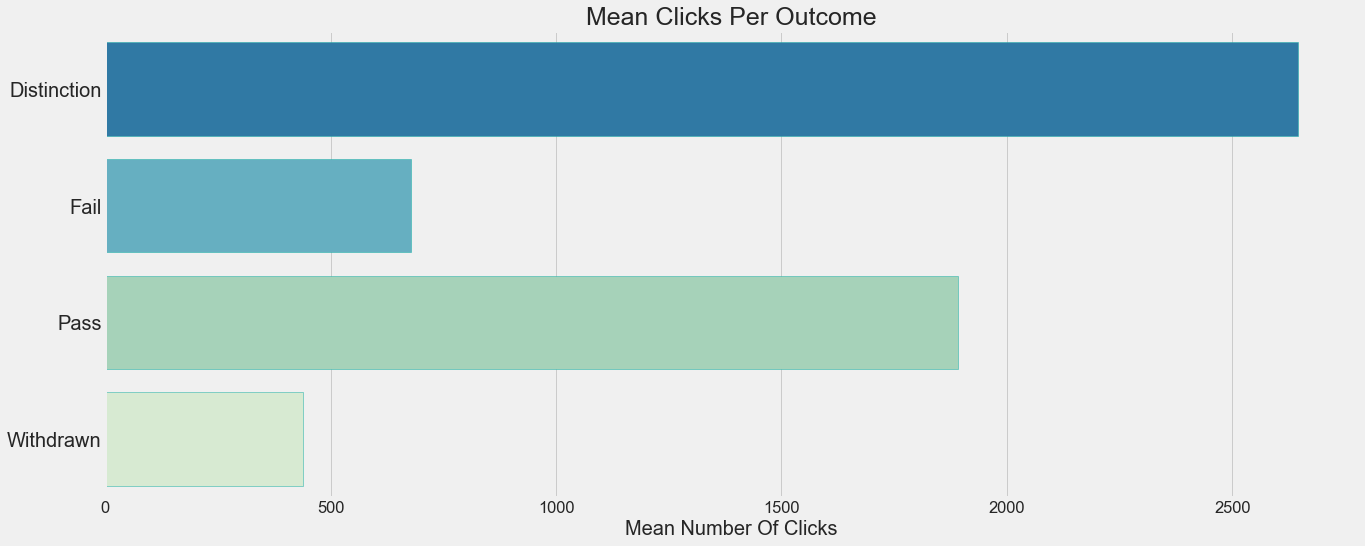

time: 137 ms


In [97]:
v.outcome_clks(sv_si)

### Mean Activities per Outcome

In [98]:
mean_activities = sv_si.groupby('final_result')['num_activities'].mean()\
.reset_index(name='mean_activities').round()

time: 8.1 ms


In [99]:
mean_activities.describe()

,mean_activities
count,4.000000
mean,375.750000
std,257.042636
min,132.000000
25%,177.750000
50%,348.500000
75%,546.500000
max,674.000000


time: 9.01 ms


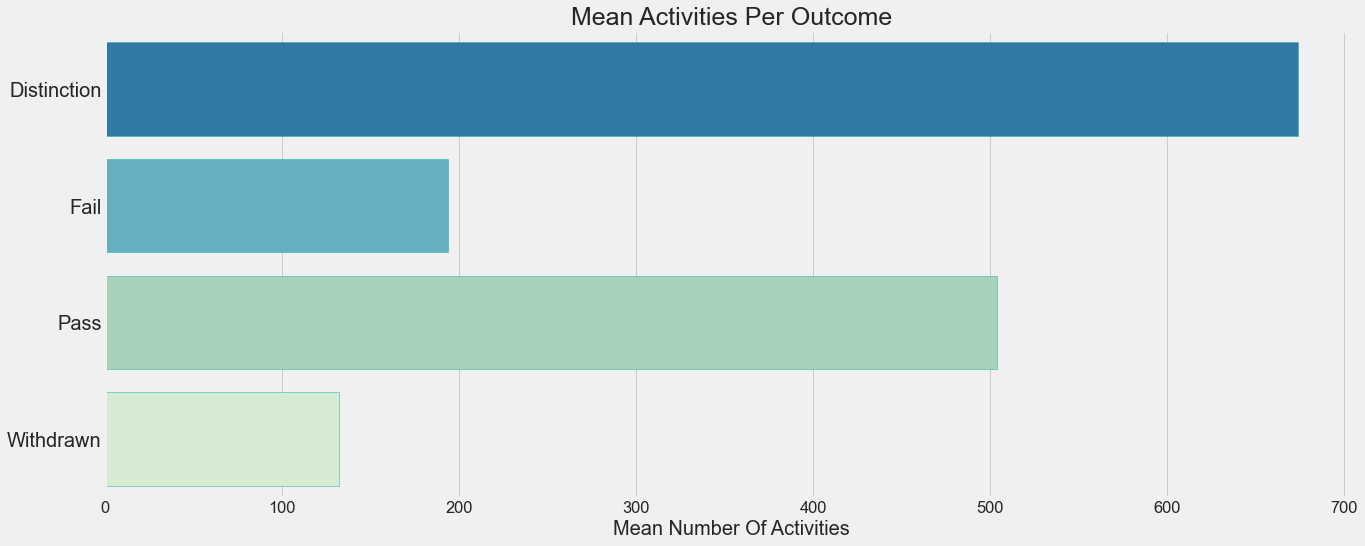

time: 144 ms


In [100]:
v.outcome_nact(sv_si)

## STUDENTASSESSMENT Data

In [101]:
stuassess = db.simple_df('STUDENTASSESSMENT')

time: 797 ms


In [102]:
# checking nulls
stuassess.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

time: 41.1 ms


In [103]:
stuassess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_assessment   173912 non-null  object
 1   id_student      173912 non-null  object
 2   date_submitted  173912 non-null  object
 3   is_banked       173912 non-null  object
 4   score           173739 non-null  object
dtypes: object(5)
memory usage: 6.6+ MB
time: 43.8 ms


In [104]:
# converting datatype
stuassess['score'] = stuassess['score'].apply(pd.to_numeric)

time: 1.95 s


In [105]:
# checking summary statistics
stuassess['score'].describe()

count    173739.000000
mean         75.799573
std          18.798107
min           0.000000
25%          65.000000
50%          80.000000
75%          90.000000
max         100.000000
Name: score, dtype: float64

time: 11.5 ms


## Mean Score Feature

In [106]:
# grouping by id_student
mean_scores = stuassess.groupby(['id_student'])['score'].mean().reset_index(name='mean_score')

time: 42.4 ms


In [107]:
sv_si = sv_si.merge(mean_scores, on='id_student')

time: 59.5 ms


In [108]:
sv_si.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25122 entries, 0 to 25121
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   row_id                25122 non-null  object  
 1   target                25122 non-null  int64   
 2   final_result          25122 non-null  object  
 3   code_module           25122 non-null  object  
 4   code_presentation     25122 non-null  object  
 5   id_student            25122 non-null  object  
 6   id_site               25122 non-null  object  
 7   date                  25122 non-null  int64   
 8   gender                25122 non-null  object  
 9   region                25122 non-null  object  
 10  highest_education     25122 non-null  object  
 11  imd_band              25122 non-null  object  
 12  age_band              25122 non-null  object  
 13  num_of_prev_attempts  25122 non-null  int64   
 14  studied_credits       25122 non-null  int64   
 15  di

In [109]:
sv_si.head()

,row_id,target,final_result,code_module,code_presentation,id_student,id_site,date,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_sum,num_activities,course_load,mean_score
0,AAA2013J100893,1,Pass,AAA,2013J,100893,547013,-9,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,No,744,243,Light,68.4
1,AAA2013J101781,1,Pass,AAA,2013J,101781,546614,-10,Male,South Region,Lower Than A Level,80-90%,35-55,0,60,No,4104,913,Light,72.6
2,AAA2013J102806,1,Pass,AAA,2013J,102806,546719,-10,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,60,No,1944,781,Light,78.0
3,AAA2013J102952,1,Pass,AAA,2013J,102952,546879,-3,Male,London Region,HE Qualification,60-70%,0-35,0,60,No,1150,313,Light,76.6
4,AAA2013J1035023,1,Pass,AAA,2013J,1035023,546652,-10,Female,London Region,Lower Than A Level,30-40%,35-55,0,60,No,1896,572,Light,70.0


time: 17 ms


## Median Score Feature

In [110]:
# grouping by id_student
median_scores = stuassess.groupby(['id_student'])['score'].median().reset_index(name='median_score')

# merging median-scores to sv_si
sv_si = sv_si.merge(median_scores, on='id_student')

time: 80 ms


In [111]:
sv_si.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25122 entries, 0 to 25121
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   row_id                25122 non-null  object  
 1   target                25122 non-null  int64   
 2   final_result          25122 non-null  object  
 3   code_module           25122 non-null  object  
 4   code_presentation     25122 non-null  object  
 5   id_student            25122 non-null  object  
 6   id_site               25122 non-null  object  
 7   date                  25122 non-null  int64   
 8   gender                25122 non-null  object  
 9   region                25122 non-null  object  
 10  highest_education     25122 non-null  object  
 11  imd_band              25122 non-null  object  
 12  age_band              25122 non-null  object  
 13  num_of_prev_attempts  25122 non-null  int64   
 14  studied_credits       25122 non-null  int64   
 15  di

In [112]:
# checking work
sv_si.head()

,row_id,target,final_result,code_module,code_presentation,id_student,id_site,date,gender,region,...,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,click_sum,num_activities,course_load,mean_score,median_score
0,AAA2013J100893,1,Pass,AAA,2013J,100893,547013,-9,Male,Yorkshire Region,...,20-30%,0-35,0,60,No,744,243,Light,68.4,68.0
1,AAA2013J101781,1,Pass,AAA,2013J,101781,546614,-10,Male,South Region,...,80-90%,35-55,0,60,No,4104,913,Light,72.6,74.0
2,AAA2013J102806,1,Pass,AAA,2013J,102806,546719,-10,Male,North Western Region,...,30-40%,0-35,0,60,No,1944,781,Light,78.0,80.0
3,AAA2013J102952,1,Pass,AAA,2013J,102952,546879,-3,Male,London Region,...,60-70%,0-35,0,60,No,1150,313,Light,76.6,76.0
4,AAA2013J1035023,1,Pass,AAA,2013J,1035023,546652,-10,Female,London Region,...,30-40%,35-55,0,60,No,1896,572,Light,70.0,72.0


time: 23.3 ms


In [113]:
stuassess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  object 
 1   id_student      173912 non-null  object 
 2   date_submitted  173912 non-null  object 
 3   is_banked       173912 non-null  object 
 4   score           173739 non-null  float64
dtypes: float64(1), object(4)
memory usage: 6.6+ MB
time: 38.4 ms


## StudentAssessment &  SV_SI

In [114]:
# merging assess & student_assessment data
sv_si_sa = stuassess.merge(sv_si, on='id_student')

time: 214 ms


In [115]:
sv_si_sa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194080 entries, 0 to 194079
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id_assessment         194080 non-null  object  
 1   id_student            194080 non-null  object  
 2   date_submitted        194080 non-null  object  
 3   is_banked             194080 non-null  object  
 4   score                 193867 non-null  float64 
 5   row_id                194080 non-null  object  
 6   target                194080 non-null  int64   
 7   final_result          194080 non-null  object  
 8   code_module           194080 non-null  object  
 9   code_presentation     194080 non-null  object  
 10  id_site               194080 non-null  object  
 11  date                  194080 non-null  int64   
 12  gender                194080 non-null  object  
 13  region                194080 non-null  object  
 14  highest_education     194080 non-nul

## Merging Assessment

In [116]:
assess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   code_module        206 non-null    object
 1   code_presentation  206 non-null    object
 2   id_assessment      206 non-null    object
 3   assessment_type    206 non-null    object
 4   date               195 non-null    object
 5   weight             206 non-null    object
dtypes: object(6)
memory usage: 9.8+ KB
time: 6.14 ms


In [117]:
drops = ['code_module', 'code_presentation', 'date', 'assessment_type']
assess_df = assess_df.drop(drops, axis=1)

time: 1.41 ms


In [118]:
# merging assess & student_assessment data
sv_si_sa = sv_si_sa.merge(assess_df, on='id_assessment')

time: 89 ms


In [119]:
sv_si_sa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194080 entries, 0 to 194079
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id_assessment         194080 non-null  object  
 1   id_student            194080 non-null  object  
 2   date_submitted        194080 non-null  object  
 3   is_banked             194080 non-null  object  
 4   score                 193867 non-null  float64 
 5   row_id                194080 non-null  object  
 6   target                194080 non-null  int64   
 7   final_result          194080 non-null  object  
 8   code_module           194080 non-null  object  
 9   code_presentation     194080 non-null  object  
 10  id_site               194080 non-null  object  
 11  date                  194080 non-null  int64   
 12  gender                194080 non-null  object  
 13  region                194080 non-null  object  
 14  highest_education     194080 non-nul

In [120]:
sv_si_sa.head()

,id_assessment,id_student,date_submitted,is_banked,score,row_id,target,final_result,code_module,code_presentation,...,age_band,num_of_prev_attempts,studied_credits,disability,click_sum,num_activities,course_load,mean_score,median_score,weight
0,1752,28400,22,0,70.0,AAA2013J28400,1,Pass,AAA,2013J,...,35-55,0,60,No,1435,430,Light,66.4,68.0,10
1,1752,31604,17,0,72.0,AAA2013J31604,1,Pass,AAA,2013J,...,35-55,0,60,No,2158,663,Light,76.0,74.0,10
2,1752,32885,26,0,69.0,AAA2013J32885,1,Pass,AAA,2013J,...,0-35,0,60,No,1034,352,Light,54.4,63.0,10
3,1752,38053,19,0,79.0,AAA2013J38053,1,Pass,AAA,2013J,...,35-55,0,60,No,2445,723,Light,68.0,69.0,10
4,1752,45462,20,0,70.0,AAA2013J45462,1,Pass,AAA,2013J,...,0-35,0,60,No,1492,355,Light,68.0,68.0,10


time: 16.9 ms


## Weighted Average Feature

In [121]:
drops = ['code_module', 'code_presentation', 'id_student']
sv_si_sa = sv_si_sa.drop(drops, axis=1)

time: 101 ms


In [122]:
sv_si_sa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194080 entries, 0 to 194079
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id_assessment         194080 non-null  object  
 1   date_submitted        194080 non-null  object  
 2   is_banked             194080 non-null  object  
 3   score                 193867 non-null  float64 
 4   row_id                194080 non-null  object  
 5   target                194080 non-null  int64   
 6   final_result          194080 non-null  object  
 7   id_site               194080 non-null  object  
 8   date                  194080 non-null  int64   
 9   gender                194080 non-null  object  
 10  region                194080 non-null  object  
 11  highest_education     194080 non-null  object  
 12  imd_band              194080 non-null  object  
 13  age_band              194080 non-null  object  
 14  num_of_prev_attempts  194080 non-nul

In [123]:
sv_si_sa['weight'] = sv_si_sa['weight'].apply(pd.to_numeric)*.01

# adjusted scores
sv_si_sa['adj_score'] = sv_si_sa['score']*sv_si_sa['weight']

# weighted_ave df
weighted_ave = sv_si_sa.groupby('row_id')['adj_score']\
.sum().reset_index().rename(columns={'adj_score': 'weighted_ave'})

time: 2.09 s


In [124]:
# merging dfs
sv_si = sv_si.merge(weighted_ave, on='row_id')

time: 24.7 ms


In [125]:
sv_si.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25122 entries, 0 to 25121
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   row_id                25122 non-null  object  
 1   target                25122 non-null  int64   
 2   final_result          25122 non-null  object  
 3   code_module           25122 non-null  object  
 4   code_presentation     25122 non-null  object  
 5   id_student            25122 non-null  object  
 6   id_site               25122 non-null  object  
 7   date                  25122 non-null  int64   
 8   gender                25122 non-null  object  
 9   region                25122 non-null  object  
 10  highest_education     25122 non-null  object  
 11  imd_band              25122 non-null  object  
 12  age_band              25122 non-null  object  
 13  num_of_prev_attempts  25122 non-null  int64   
 14  studied_credits       25122 non-null  int64   
 15  di

In [126]:
# checking first five rows
sv_si.head(2)

,row_id,target,final_result,code_module,code_presentation,id_student,id_site,date,gender,region,...,age_band,num_of_prev_attempts,studied_credits,disability,click_sum,num_activities,course_load,mean_score,median_score,weighted_ave
0,AAA2013J100893,1,Pass,AAA,2013J,100893,547013,-9,Male,Yorkshire Region,...,0-35,0,60,No,744,243,Light,68.4,68.0,68.7
1,AAA2013J101781,1,Pass,AAA,2013J,101781,546614,-10,Male,South Region,...,35-55,0,60,No,4104,913,Light,72.6,74.0,71.6


time: 16.6 ms


In [161]:
sv_si.describe()

,target,date,num_of_prev_attempts,studied_credits,click_sum,num_activities,mean_score,median_score,weighted_ave
count,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000
mean,0.580807,-8.496674,0.154962,75.764251,1468.167829,394.234354,72.744172,73.656694,72.797718
std,0.493437,12.471198,0.466519,34.944846,1752.887108,377.172463,15.565906,16.042592,64.785499
min,0.000000,-25.000000,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,-17.000000,0.000000,60.000000,363.000000,128.000000,64.679487,65.000000,19.875000
50%,1.000000,-10.000000,0.000000,60.000000,854.000000,275.000000,75.666667,77.000000,67.840000
75%,1.000000,-4.000000,0.000000,90.000000,1910.500000,538.000000,84.000000,85.000000,90.000000
max,1.000000,234.000000,6.000000,210.000000,24139.000000,3078.000000,100.000000,100.000000,477.190000


time: 48.8 ms


## Visualization For Student Assessment Data

## Mean Weighted Average

In [127]:
# mean weighted average
mean_wa = sv_si.groupby('final_result')['weighted_ave'].mean()\
.reset_index(name='mean_wa').round()

time: 8.19 ms


In [128]:
# checking values
mean_wa

,final_result,mean_wa
0,Distinction,119.0
1,Fail,39.0
2,Pass,93.0
3,Withdrawn,37.0


time: 4.36 ms


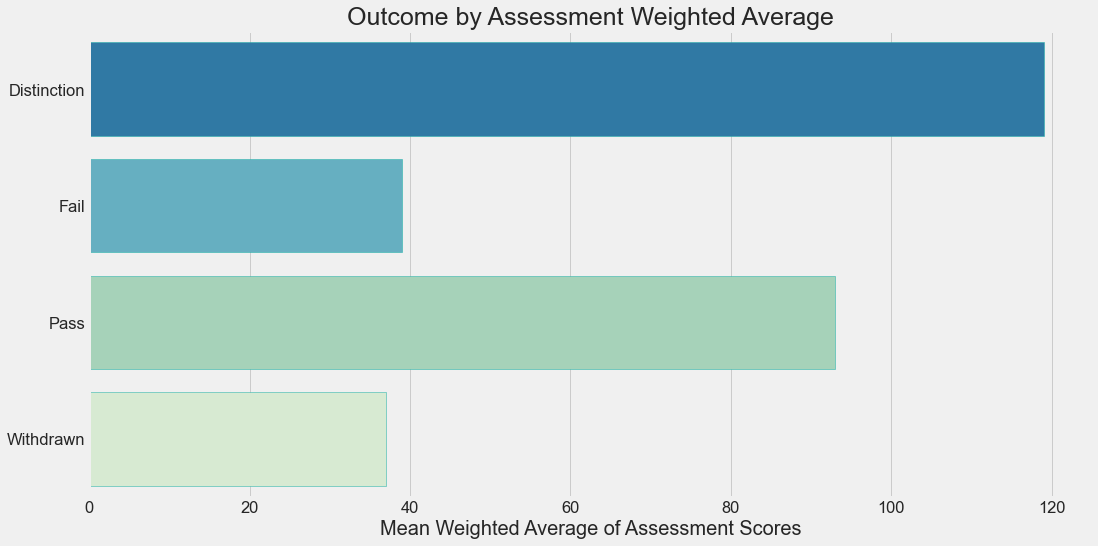

time: 258 ms


In [129]:
v.outcomes_wa(sv_si, 'outcomes_wa')

## Average Median Assessment Score

In [130]:
mms = sv_si.groupby('final_result')['median_score'].mean()\
.reset_index(name='mean_ms').round()
mms

,final_result,mean_ms
0,Distinction,89.0
1,Fail,65.0
2,Pass,77.0
3,Withdrawn,67.0


time: 12.9 ms


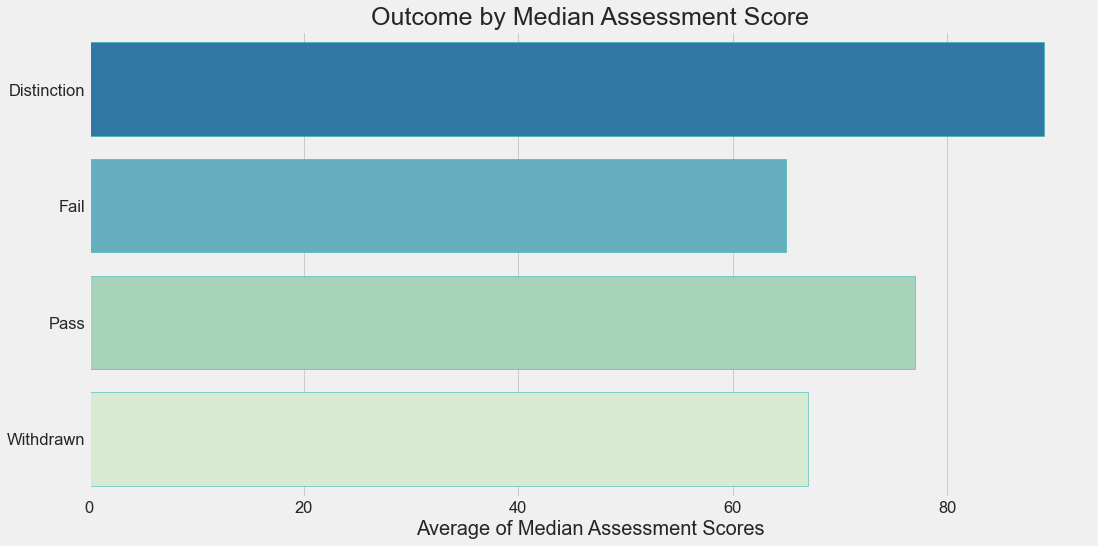

time: 243 ms


In [131]:
v.outcomes_med(sv_si, 'outcomes_med')

## Average Mean Assessment Score 

In [132]:
# mean weighted average
mean_scores = sv_si.groupby('final_result')['mean_score'].mean()\
.reset_index(name='mean_score').round()

time: 14.4 ms


In [133]:
# checking values
mean_scores

,final_result,mean_score
0,Distinction,88.0
1,Fail,64.0
2,Pass,76.0
3,Withdrawn,66.0


time: 7.76 ms


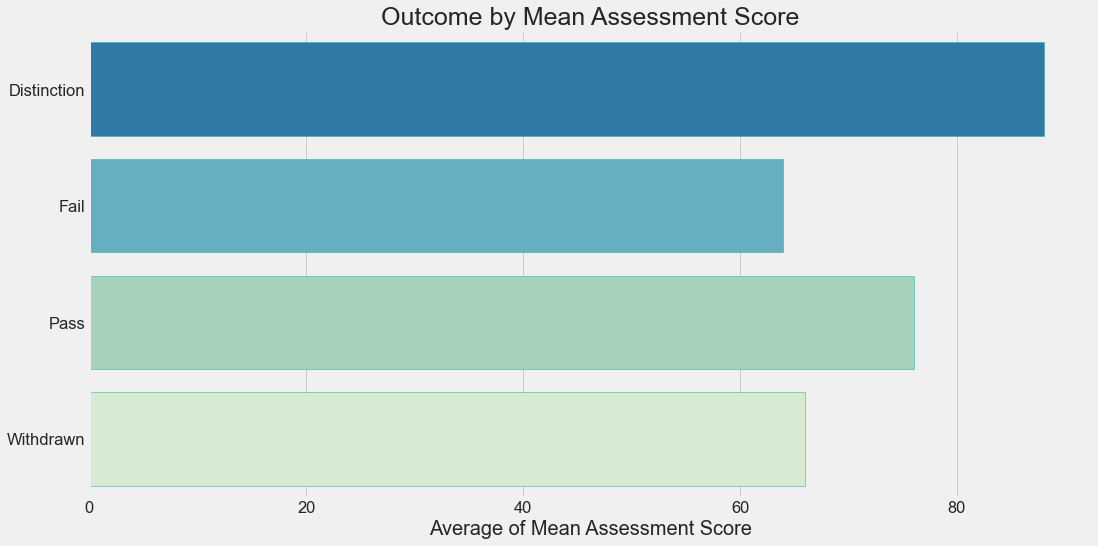

time: 211 ms


In [134]:
v.outcomes_mean(sv_si)

## Merging Base Data Frame & Student Assessment Data

In [135]:
sv_si.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25122 entries, 0 to 25121
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   row_id                25122 non-null  object  
 1   target                25122 non-null  int64   
 2   final_result          25122 non-null  object  
 3   code_module           25122 non-null  object  
 4   code_presentation     25122 non-null  object  
 5   id_student            25122 non-null  object  
 6   id_site               25122 non-null  object  
 7   date                  25122 non-null  int64   
 8   gender                25122 non-null  object  
 9   region                25122 non-null  object  
 10  highest_education     25122 non-null  object  
 11  imd_band              25122 non-null  object  
 12  age_band              25122 non-null  object  
 13  num_of_prev_attempts  25122 non-null  int64   
 14  studied_credits       25122 non-null  int64   
 15  di

In [136]:
sv_si.isna().sum()

row_id                   0
target                   0
final_result             0
code_module              0
code_presentation        0
id_student               0
id_site                  0
date                     0
gender                   0
region                   0
highest_education        0
imd_band                 0
age_band                 0
num_of_prev_attempts     0
studied_credits          0
disability               0
click_sum                0
num_activities           0
course_load              0
mean_score              19
median_score            19
weighted_ave             0
dtype: int64

time: 23.4 ms


In [137]:
sv_si = sv_si.dropna()

time: 46.6 ms


In [138]:
sv_si.isna().sum()

row_id                  0
target                  0
final_result            0
code_module             0
code_presentation       0
id_student              0
id_site                 0
date                    0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
click_sum               0
num_activities          0
course_load             0
mean_score              0
median_score            0
weighted_ave            0
dtype: int64

time: 22.9 ms


In [139]:
sv_si.target.value_counts(normalize=True)

1    0.580807
0    0.419193
Name: target, dtype: float64

time: 3.79 ms


In [140]:
sv_si.describe()

,target,date,num_of_prev_attempts,studied_credits,click_sum,num_activities,mean_score,median_score,weighted_ave
count,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000,25103.000000
mean,0.580807,-8.496674,0.154962,75.764251,1468.167829,394.234354,72.744172,73.656694,72.797718
std,0.493437,12.471198,0.466519,34.944846,1752.887108,377.172463,15.565906,16.042592,64.785499
min,0.000000,-25.000000,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,-17.000000,0.000000,60.000000,363.000000,128.000000,64.679487,65.000000,19.875000
50%,1.000000,-10.000000,0.000000,60.000000,854.000000,275.000000,75.666667,77.000000,67.840000
75%,1.000000,-4.000000,0.000000,90.000000,1910.500000,538.000000,84.000000,85.000000,90.000000
max,1.000000,234.000000,6.000000,210.000000,24139.000000,3078.000000,100.000000,100.000000,477.190000


time: 29 ms


In [141]:
# path = os.path.join(gparent, 'data/processed/df2.csv')
# sv_si.to_csv(path, index=False)

time: 525 µs


## Getting Trace Data

In [142]:
# pivoting data frame and summing sum_clicks by day
sv_pivot = svle.pivot_table(
    index='date', columns=['row_id'],
    values='sum_click', aggfunc=[np.sum], fill_value=0)

# setting row_ids as column_names and resetting index
sv_pivot.columns = sv_pivot.columns.to_flat_index()
sv_pivot.columns = [sv_pivot.columns[i][1] for i in range(len(sv_pivot.columns))] 
sv_pivot = sv_pivot.reset_index(drop=True)

# transposing data frame
sv_unpivot = sv_pivot.T

# resetting index, renaming column and saving to sv_time
sv_unpivot = sv_unpivot.reset_index()
sv_time = sv_unpivot.rename(columns = {'index': 'row_id'})

time: 17 s


In [143]:
# checking work
sv_time.head()

,row_id,0,1,2,3,4,5,6,7,8,...,285,286,287,288,289,290,291,292,293,294
0,AAA2013J100893,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAA2013J101781,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
2,AAA2013J102806,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
3,AAA2013J102952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAA2013J1035023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 10.8 ms


## Merging SI & SV_time data

In [144]:
svsi_time = sv_si.merge(sv_time, on='row_id')

time: 119 ms


In [145]:
# checking work
svsi_time.head()

,row_id,target,final_result,code_module,code_presentation,id_student,id_site,date,gender,region,...,285,286,287,288,289,290,291,292,293,294
0,AAA2013J100893,1,Pass,AAA,2013J,100893,547013,-9,Male,Yorkshire Region,...,0,0,0,0,0,0,0,0,0,0
1,AAA2013J101781,1,Pass,AAA,2013J,101781,546614,-10,Male,South Region,...,0,0,0,0,0,0,0,0,10,0
2,AAA2013J102806,1,Pass,AAA,2013J,102806,546719,-10,Male,North Western Region,...,0,0,0,0,0,0,0,2,0,0
3,AAA2013J102952,1,Pass,AAA,2013J,102952,546879,-3,Male,London Region,...,0,0,0,0,0,0,0,0,0,0
4,AAA2013J1035023,1,Pass,AAA,2013J,1035023,546652,-10,Female,London Region,...,0,0,0,0,0,0,0,0,0,0


time: 15.3 ms


In [146]:
svsi_time.num_activities.describe()

count    25103.000000
mean       394.234354
std        377.172463
min          1.000000
25%        128.000000
50%        275.000000
75%        538.000000
max       3078.000000
Name: num_activities, dtype: float64

time: 5.54 ms


## Q1 Clicks Feature

In [147]:
# filter q1 click data
q1 = svsi_time.iloc[:, 22:97]

# summing clicks
svsi_time['q1_clicks'] = q1.sum(axis=1)

# creating activity feature
svsi_time['q1_clicks'] = pd.qcut(svsi_time.q1_clicks, q=4,\
                                      labels=['Light', 'Medium', 'Heavy', 'Very Heavy'],\
                                      duplicates='drop')

time: 14.9 ms


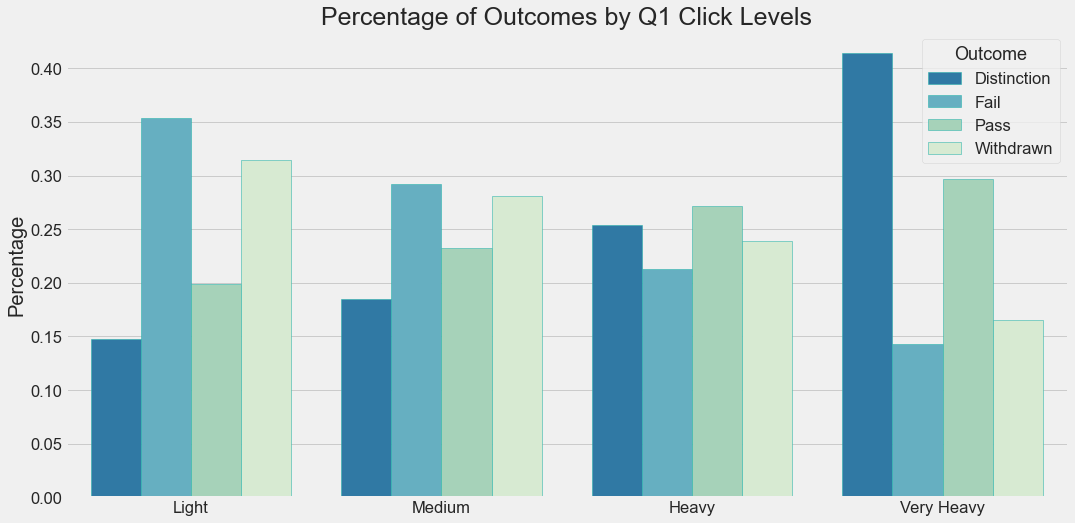

time: 357 ms


In [148]:
v.outcomes_qc(svsi_time, 'outcomes_al')

## Weighted Ave SQL

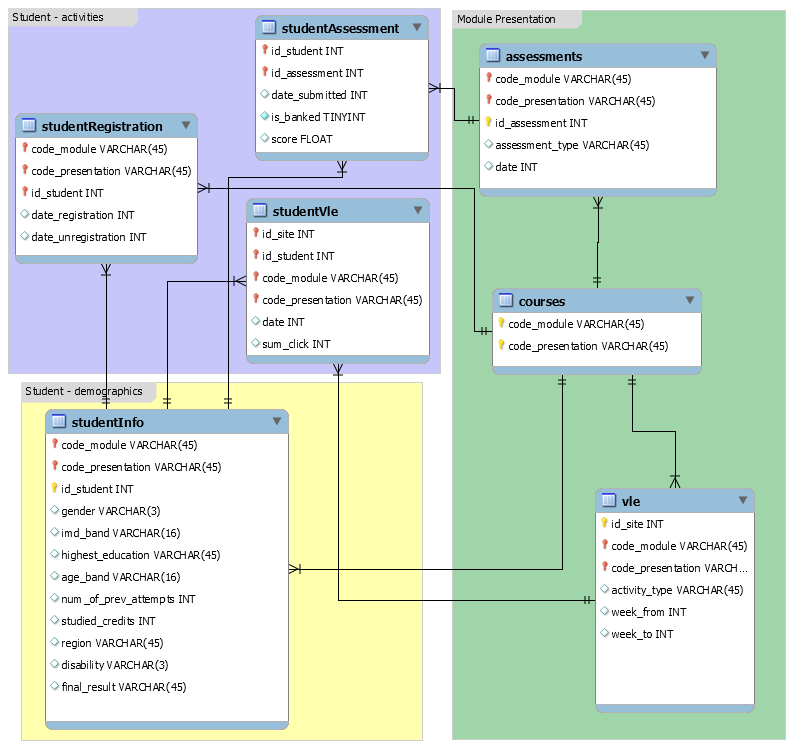

time: 7.25 ms


In [149]:
db.erd

### demo data, row_id, target, mean_score, weighted_ave (need median_score, course_load)

In [150]:
q = """
SELECT
/*selecting all from multiple tables*/
SI.*,
SA.*,
/* creating the row_id column by concatenation*/
SI.code_module || SI.code_presentation || SI.id_student AS row_id,
/* creating binarized target column*/
iif(SI.final_result='Pass' OR SI.final_result='Distinction', 0, 1) AS target,
/* creating weighted_ave column*/
SUM(SA.score*A.weight*.01) AS weighted_ave,
/* creating mean_score column*/
AVG(SA.score) as mean_score
FROM STUDENTASSESSMENT AS SA
JOIN
ASSESSMENTS AS A
ON A.id_assessment = SA.id_assessment
JOIN STUDENTINFO AS SI
ON SI.id_student = SA.id_student
GROUP BY SA.id_student,
SI.code_module,
SI.code_presentation;
"""

si_sa = pd.read_sql(q, conn)

time: 950 ms


In [151]:
si_sa.target.value_counts(normalize=True)

0    0.575151
1    0.424849
Name: target, dtype: float64

time: 3.99 ms


###  module_presentation_length, row_id, click_sum

In [152]:
q="""
SELECT
/*selecting all from multiple tables*/
SV.*,
C.*,
/* creating the row_id column by concatenation*/
SV.code_module || SV.code_presentation || SV.id_student AS row_id,
/* creating the click_sum column*/
SUM(SV.sum_click) AS click_sum,
/* creating the num_activities column*/
COUNT(SV.sum_click) AS num_activities
FROM
STUDENTVLE AS SV
JOIN COURSES AS C
ON C.code_module = SV.code_module
AND C.code_presentation = SV.code_presentation
GROUP BY 
C.code_module,
C.code_presentation,
SV.id_student;
"""

svc = pd.read_sql(q, conn)

time: 19.6 s


In [153]:
svc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 29228 non-null  object
 1   code_presentation           29228 non-null  object
 2   id_student                  29228 non-null  object
 3   id_site                     29228 non-null  object
 4   date                        29228 non-null  object
 5   sum_click                   29228 non-null  object
 6   code_module                 29228 non-null  object
 7   code_presentation           29228 non-null  object
 8   module_presentation_length  29228 non-null  object
 9   row_id                      29228 non-null  object
 10  click_sum                   29228 non-null  int64 
 11  num_activities              29228 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 2.7+ MB
time: 29.6 ms


In [154]:
svc.describe()

,click_sum,num_activities
count,29228.000000,29228.000000
mean,1355.039654,364.557274
std,1733.546045,378.351476
min,1.000000,1.000000
25%,260.750000,93.000000
50%,739.500000,242.000000
75%,1770.000000,510.000000
max,24139.000000,3078.000000


time: 19.6 ms
